ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **13May21**

# 10. Peclet 1D with Neumann Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Poisson-Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [High Peclet Number](#highpe)
 + [Quadratic Lagrange FEM Results](#highperesults1)
    - [Compute Error](#highperesults1error)
 + [Quadratic Lagrange FEM Results](#highperesults2)
    - [Compute Error](#highperesults2error)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

+ Use a Neumann boundary condition in conjuction with the Peclet problem; all past notebooks must be thoroughly reviewed in particular the notebooks solving the Peclet-Dirichlet problem and the Poisson-Neumann problem.
+ Introduce the Galerkin weak form of the Peclet 1D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
+ <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span> 
+ The reader is supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the one-dimensional Peclet problem with Dirichlet boundary conditions.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
  v\, u' &= -\bigl(-D\, u'\bigr)'(x) + S \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 q_n(b) &= q_{nb}.
\end{align*}
   
This problem has an analytical solution and you should obtain it for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, exit normal flux, $q_{nb}$, and speed $v$. The *diffusion flux* associated to the quantity $u$, is denoted $q := -D\,u'$, and it is often of interest as a derived quantity. Here a point-wise *convective sink (or sweep)* is given by $v\,u'$. This term introduces an important feature in the problem which is measured by the 

  + Peclet number: $\frac{v\,L}{D}$. 

If this value is much greater than unity, the convection term dominates diffusion and a strong sweep of the dependent variable in the direction of the velocity $v$ leads to a one-sided transmission of information (this is referred to as a hyperbolic character; or wave-like property). As it will be seen, this can lead to sharp gradients of $u$ near boundaries which challenges numerical methods.

Likewise in the Poisson-Neumann 1-D problem (Notebook 07), a mix of Dirichlet boundary condition on the entry point, and a normal flux boundary condition on the exit point, are applied. 

### [Weak Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b v\, u'(x)\, w(x)\,dx + \int\limits_a^b D\, u'(x)\,w'(x)\,dx + q_n(b)\,v(b) - \int\limits_a^b S\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

All terms have been previously implemented on the Poisson-Dirichlet and Peclet-Dirichlet problems. The `MOOSE` application is essentially ready to be used.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

The **Poisson-Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}\bigl(q(x)\bigr)^2 - D\,S\,u(x) \,dx + D\,q_n(b)\,u(b).
\end{align*}

is no longer of interest because the solution of the strong form is not a minimum of this functional and there is no extension of this energy to the Peclet problem. That is to say, the Peclet problem is not the Euler-Lagrange problem of any energy minimization. Although this functional can be computed as an exercise, it does not have a relationship with the weak form.

## [Problem Solution](#toc)<a id="solution"></a>

We will leverage the Peclet-Dirichlet 1D development (Notebook 09) and the Poisson-Neumann 1D development (notebook 07) to solve the problem at hand. Therefore there is no new implementation to be done.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0 g/cm^2-s  (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 1

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 10

In [2]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [3]:
'''Parameters and data'''

Pe = 1 # mildly convective dominated

diff_coeff = 0.1
source_s = 5e-2

velocity = (Pe * diff_coeff/x_length, 0, 0)  # length scale is the x length

u_a = 3

qn_b = 0 # no flux on the exit point

In [4]:
'''FEM Solution'''

n_felem = 10

order = 'first'

n_plot_pts = n_felem + 1
n_plot_pts *=2

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, qn_bias_right=qn_b,
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity, 
                                n_felem=n_felem,
                                order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True)

In [5]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 18Apr21 18:44:32

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
velocity = '4.00000e-03 0.00000e+00 0.00000e+00'
qn_bias_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = CONSTANT
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = CONSTANT
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
  [convection-term]
    ty

In [6]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun Apr 18 18:44:32 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 11
    Local:                 11
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                11
  Num Local DOFs:          11
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                20
  Num Local DOFs:          20
  Variabl

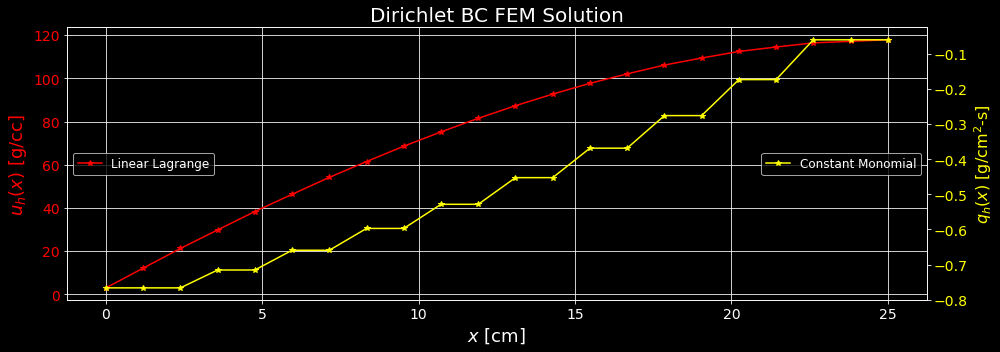

In [7]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. Convection reduces the curvature of the solution as compared with the corresponding Poisson problem.

### [FEM Error](#toc)<a id="linearerror"></a>

In [8]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

**Comments:**

1. TBA
1. TBA

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0 g/cm^2-s  (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 10

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

In [9]:
'''Parameters and data'''

Pe = 10 # mildly convective dominated

velocity = (Pe * diff_coeff/x_length, 0, 0)  # length scale is the x length

In [10]:
'''FEM Solution'''

n_felem = 10

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts *=2 

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, qn_bias_right=qn_b,
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True, use_moose_neumann_bc=True)

In [11]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 18Apr21 18:44:33

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
velocity = '4.00000e-02 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
  [convection-term]
    type = Convec

In [12]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun Apr 18 18:44:34 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 21
    Local:                 21
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                21
  Num Local DOFs:          21
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                40
  Num Local DOFs:          40
  Variab

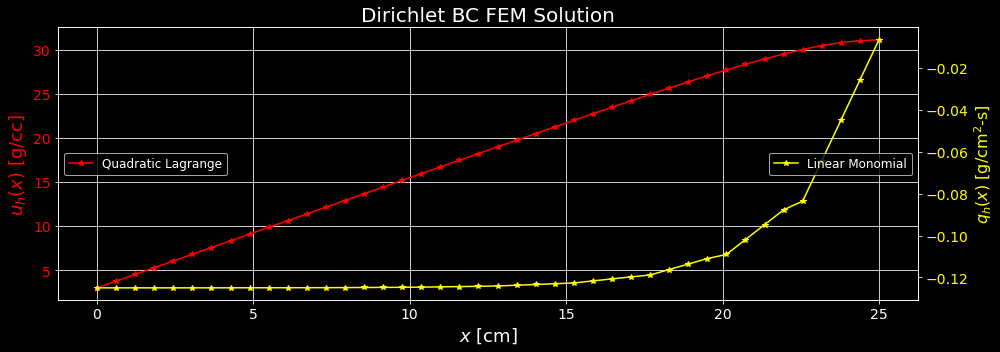

In [13]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

A boundary layer on the flux variable begins to form on the right side of the domain.

### [FEM Error](#toc)<a id="quaderror"></a>


In [14]:
'''Error Compared to Exact Dimensionless Solution'''

'''comming...'''

'comming...'

**Comments:**

1. TBA

## [High Peclet Number](#toc)<a id="highpe"></a>

Highly convective problems lead to numerical difficulties. Below, artificial (numerical) oscillations are present near a boundary. 

### [Quadratic Lagrange FEM](#toc)<a id="highperesults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + qn_b = 0 g/cm^2-s  (the bias parameter)
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 50

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

In [15]:
'''Parameters and data'''

Pe = 50 # convective dominated

velocity = (Pe * diff_coeff/x_length, 0, 0)

In [16]:
'''FEM Solution'''

n_felem = 10

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts *= 2

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_a, x_b, u_left=u_a, qn_bias_right=qn_b,
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity,
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts, 
                                compute_diffusion_flux=True)

In [17]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 18Apr21 18:44:34

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
velocity = '2.00000e-01 0.00000e+00 0.00000e+00'
qn_bias_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
  [convec

In [18]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun Apr 18 18:44:34 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 21
    Local:                 21
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                21
  Num Local DOFs:          21
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                40
  Num Local DOFs:          40
  Variab

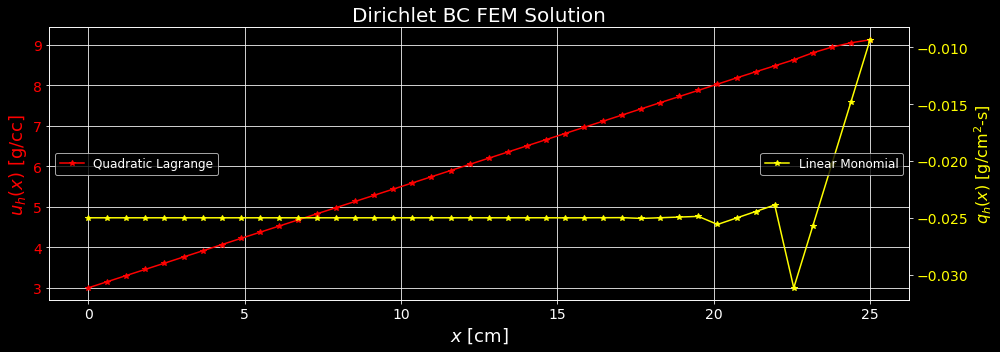

In [19]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

As convection dominates, the boundary layer sharpens and *numerical wiggles* appear. In this case the flux suffers from oscillations. This effect is often interpreted as a *numerical instability*. It can be treated by:

 1. Using additional finite element basis functions (not scalable) 
 2. Adapting the mesh (mesh adaptivity); involved but doable
 3. "Stabilizing the weak formulation" or other methods called artificial viscosity or flux "upwinding"

#### [Compute Error](#toc)<a id="highperesults1error"></a>


In [20]:
'''Flux Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

### [Quadratic Lagrange FEM](#toc)<a id="highperesults2"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 50

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 20

In [21]:
'''FEM Solution'''

n_felem = 50

x_bias = 0.8

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts *= 2

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, qn_bias_right=qn_b,
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity,
                                n_felem=n_felem, x_bias=x_bias,
                                order=order, 
                                n_plot_pts=n_plot_pts, 
                                compute_diffusion_flux=True)

In [22]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 18Apr21 18:44:35

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 5.00000e-02
velocity = '2.00000e-01 0.00000e+00 0.00000e+00'
qn_bias_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 50
    elem_type = edge3
    bias_x = 8.000e-01
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace s

In [23]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun Apr 18 18:44:35 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 101
    Local:                 101
  Elems:                   
    Total:                 50
    Local:                 50
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                101
  Num Local DOFs:          101
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                200
  Num Local DOFs:          200
  

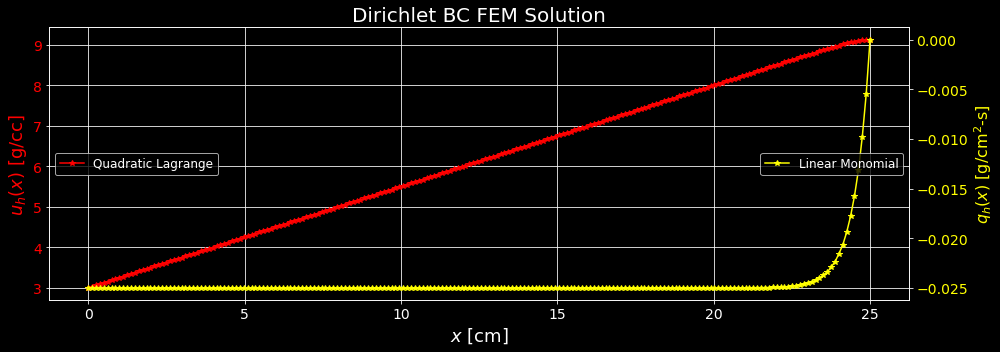

In [24]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. The mesh refinement captures the boundary layer on the flux.

#### [Compute Error](#toc)<a id="highperesults2error"></a>

In [25]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming'''

'coming'

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [26]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 